# Jakost gibanja plosce s tipali SensorTile.box

## Pregled ali se v Orange Data Mining izvede predprocesiranje podatkov pred klasifikacijo z metodo podpornih vektorjev (V tem primeru se zamenjajo manjkajoce vrednosti (ki jih v nasih podatkih ni), nato se vsem vrednostim odsteje odmik ("offset") in se jih pomnozi s faktorjem ("factor")) 

In [2]:
import pickle

with open('../../Orange_Data_Mining/Jakost_gibanja/Metoda_podpornih_vektorjev-Jakost_gibanja.pkcls', 'rb') as model:
    lr = pickle.load(model)

#lr.domain
lr.domain[0]

ContinuousVariable(name='F1_VAR_on_ACC_V',
                   number_of_decimals=3,
                   compute_value=Normalizer(variable=ContinuousVariable(name='F1_VAR_on_ACC_V',
                                                 number_of_decimals=3,
                                                 compute_value=ReplaceUnknowns(variable=ContinuousVariable(name='F1_VAR_on_ACC_V',
                                                                                    number_of_decimals=3),
                                                                 value=0.22330145150297734)),
                              offset=0.22330145150297734,
                              factor=2.5709241370783027))

## Preoblikovanje testnih podatkov iz NanoEdge AI Studio za uporabo pri validacija modela metode podpornih vektorjev v X-CUBE-AI (glede na zgornje ugotovitve o predprocesiranju podatkov)

In [4]:
# SPREMEMBA TESTNIH PODATKOV ZA SVM
import Orange
import pickle
import pandas as pd

# pickleFileSVM -> pickle file with the SVM model
# testDataFiles -> list of csv files with test data obtained from NanoEdge AI Studio data manipulation
# testDataFilesSVM -> list of csv files where altered test data for testing the SVM model in X-CUBE-AI will be written (these output files should be in the same order 
# as the input files in testDataFiles from which the data will be altered)
def testDataForSVM(pickleFileSVM, testDataFiles, testDataFilesSVM):
    with open(pickleFileSVM, 'rb') as model:
        lr = pickle.load(model)


    for indeks, dat in enumerate(testDataFiles):
        df = pd.read_csv(dat, header=None, names=["vrednost"])
        df["vrednost"] = (df["vrednost"] - lr.domain[0].compute_value.offset) * lr.domain[0].compute_value.factor
        df.to_csv(testDataFilesSVM[indeks], index=False, header=False)



datoteke = ["../../Zajeti_podatki/Jakost_gibanja/Testni_podatki/mirovanje-NEAIS.csv",
            "../../Zajeti_podatki/Jakost_gibanja/Testni_podatki/srednja_jakost-NEAIS.csv",
            "../../Zajeti_podatki/Jakost_gibanja/Testni_podatki/velika_jakost-NEAIS.csv"]

datotekeSVM = ["../../Zajeti_podatki/Jakost_gibanja/Testni_podatki/SVM-mirovanje-NEAIS.csv",
              "../../Zajeti_podatki/Jakost_gibanja/Testni_podatki/SVM-srednja_jakost-NEAIS.csv",
              "../../Zajeti_podatki/Jakost_gibanja/Testni_podatki/SVM-velika_jakost-NEAIS.csv"]

svmModel = '../../Orange_Data_Mining/Jakost_gibanja/Metoda_podpornih_vektorjev-Jakost_gibanja.pkcls'

testDataForSVM(svmModel, datoteke, datotekeSVM)

## Pretvorba metode podpornih vektorjev iz Orange Data Mining v ONNX format

In [29]:
import pickle

# pickleFile -> pickle file with SVM model
# onnxFile -> new onnx file with model converted from pickle file
# numberOffloatInputs -> number of features (here we are using floating point values (FloatTensorType), 
# if you want to use other data types they can be found in skl2onnx.common.data_types from the skl2onnx library)
def orangeToONNX(pickleFile, onnxFile, numberOffloatInputs):

    with open(pickleFile, 'rb') as model:
        lr = pickle.load(model)

    skl_model = lr.skl_model



    from skl2onnx import convert_sklearn
    from skl2onnx.common.data_types import FloatTensorType

    initial_type = [('float_input', FloatTensorType([None, numberOffloatInputs]))]
    onx = convert_sklearn(skl_model, initial_types=initial_type)
    with open(onnxFile, "wb") as f:
        f.write(onx.SerializeToString())


svm = '../../Orange_Data_Mining/Jakost_gibanja/Metoda_podpornih_vektorjev-Jakost_gibanja.pkcls'
svmONNX = "Metoda_podpornih_vektorjev-Jakost_gibanja-ONNX.onnx"

orangeToONNX(svm, svmONNX, 1)

## Izracun klasifikacijske tocnosti in mere F1 ter prikaz tabele napacnih klasifikacij (Rezultati iz X-CUBE-AI)

Klasifikacijska tocnost: 0.7934782608695652
Mera F1: 0.7729396977972504


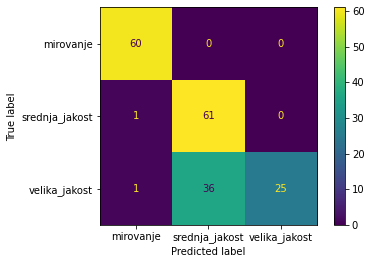

In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# datoteke -> list of csv files with classification results (files must be written in order of classification class indices (alphabeticall order of class names))
# imenaRazredov -> list of class names for values to be classified to (order is not important as it gets sorted alphabetically)
def CA_F1_Matrix(datoteke, imenaRazredov):
    dfPred = pd.DataFrame()
    arrayTrue = []

    for indeks, dat in enumerate(datoteke):
        df = pd.read_csv(dat, skiprows=[1, 2, 3]) 
        df.columns.values[0] = "class"

        dfPred = pd.concat([dfPred, df], axis=0)

        countVal = 0

        for i in df['class'].value_counts().index:
            countVal += df['class'].value_counts()[i]

        arrayTrue += [indeks] * countVal


    ###### Print classification accuracy and F1 score
    ca = accuracy_score(arrayTrue, dfPred['class'].values.tolist())
    f1 = f1_score(arrayTrue, dfPred['class'].values.tolist(), average='weighted')

    print("Klasifikacijska tocnost: " + str(ca))
    print("Mera F1: " + str(f1))

    ###### Display confusion matrix
    matrika = confusion_matrix(arrayTrue, dfPred['class'].values.tolist())

    orderedClassNames = imenaRazredov.copy()
    orderedClassNames.sort()

    disp = ConfusionMatrixDisplay(confusion_matrix=matrika, display_labels=orderedClassNames)
    disp.plot()
    plt.show()


###################################################################################################################################################################################


datoteke = ["../../Zajeti_podatki/Jakost_gibanja/Rezultati_klasifikacij-X-CUBE-AI/Metoda_podpornih_vektorjev/validacija-mirovanje.csv",
            "../../Zajeti_podatki/Jakost_gibanja/Rezultati_klasifikacij-X-CUBE-AI/Metoda_podpornih_vektorjev/validacija-srednja_jakost.csv",
            "../../Zajeti_podatki/Jakost_gibanja/Rezultati_klasifikacij-X-CUBE-AI/Metoda_podpornih_vektorjev/validacija-velika_jakost.csv"]

imenaRazredov = ["mirovanje", "srednja_jakost", "velika_jakost"]

CA_F1_Matrix(datoteke, imenaRazredov)

## NanoEdge AI Studio: Izracun klasifikacijske tocnosti in mere F1 ter prikaz tabele napacnih klasifikacij (Rezultati modela metode podpornih vektorjev iz NanoEdge AI Studio)

Klasifikacijska tocnost: 0.8858695652173914
Mera F1: 0.8818056762025257


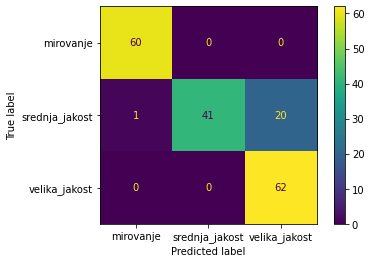

In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# trueClasses -> list of true classification classes
# predictedClasses -> list of predicted classification classes (has to be same length as trueClasses)
# classNames -> list of classification class names (in alphabetical order)
def NEAIS_CA_F1_Matrix(trueClasses, predictedClasses, classNames):
    ca = accuracy_score(trueClasses, predictedClasses)
    f1 = f1_score(trueClasses, predictedClasses, average='weighted')
    print("Klasifikacijska tocnost: " + str(ca))
    print("Mera F1: " + str(f1))

    matrika = confusion_matrix(trueClasses, predictedClasses)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=matrika, display_labels=classNames)
    disp.plot()
    plt.show()


arrayPredicted = [0] * 60 + [1] * 41 + [0] * 1 + [2] * 20 + [2] * 62
arrayTrue = [0] * 60 + [1] * 62 + [2] * 62
imenaRazredov = ["mirovanje", "srednja_jakost", "velika_jakost"]
NEAIS_CA_F1_Matrix(arrayTrue, arrayPredicted, imenaRazredov)

---

# Hoja oseb

## Pregled ali se v Orange Data Mining izvede predprocesiranje podatkov pred klasifikacijo z metodo podpornih vektorjev (V tem primeru se zamenjajo manjkajoce vrednosti vseh 16ih atributov (ki jih v nasih podatkih ni), nato se vsem vrednostim vseh 16ih atributov odsteje odmik ("offset") in se jih pomnozi s faktorjem ("factor")) 

In [25]:
import pickle

with open('../../Orange_Data_Mining/Hoja_oseb/Metoda_podpornih_vektorjev-Hoja_oseb.pkcls', 'rb') as model:
    lr = pickle.load(model)

#lr.domain
#lr.domain[0]
#lr.domain[1]
#lr.domain[2]
#lr.domain[3]
#lr.domain[4]
#lr.domain[5]
#lr.domain[6]
#lr.domain[7]
#lr.domain[8]
#lr.domain[9]
#lr.domain[10]
#lr.domain[11]
#lr.domain[12]
#lr.domain[13]
#lr.domain[14]
lr.domain[15]

ContinuousVariable(name='F16_acc_Magnituda_RMS',
                   number_of_decimals=2,
                   compute_value=Normalizer(variable=ContinuousVariable(name='F16_acc_Magnituda_RMS',
                                                 number_of_decimals=3,
                                                 compute_value=ReplaceUnknowns(variable=ContinuousVariable(name='F16_acc_Magnituda_RMS',
                                                                                    number_of_decimals=3),
                                                                 value=1.1134635041015108)),
                              offset=1.1134635041015108,
                              factor=10.457188751844905))

## Preoblikovanje testnih podatkov iz NanoEdge AI Studio za uporabo pri validacija modela metode podpornih vektorjev v X-CUBE-AI (glede na zgornje ugotovitve o predprocesiranju podatkov)

In [26]:
# SPREMEMBA TESTNIH PODATKOV ZA SVM
import Orange
import pickle
import pandas as pd

# pickleFileSVM -> pickle file with the SVM model
# testDataFiles -> list of csv files with test data obtained from NanoEdge AI Studio data manipulation
# testDataFilesSVM -> list of csv files where altered test data for testing the SVM model in X-CUBE-AI will be written (these output files should be in the same order 
# as the input files in testDataFiles from which the data will be altered)
# atributi -> list of features (feature names are not important as long as there are as many features as there are columns in a testDataFiles file and no two feature names are same),
# they will be used in the same order as they are in the columns of testDataFiles
def testDataForSVM_MultipleFeatures(pickleFileSVM, testDataFiles, testDataFilesSVM, atributi):
    with open(pickleFileSVM, 'rb') as model:
        lr = pickle.load(model)

    for indeks, dat in enumerate(testDataFiles):
        df = pd.read_csv(dat, header=None, names=atributi)
        for indeks2, atr in enumerate(atributi):
            df[atr] = (df[atr] - lr.domain[indeks2].compute_value.offset) * lr.domain[indeks2].compute_value.factor
        df.to_csv(testDataFilesSVM[indeks], index=False, header=False)


datoteke = ["../../Zajeti_podatki/Hoja_oseb/Testni_podatki/Jaz-testiranje-NEAIS.csv",
            "../../Zajeti_podatki/Hoja_oseb/Testni_podatki/Mami-testiranje-NEAIS.csv",
            "../../Zajeti_podatki/Hoja_oseb/Testni_podatki/Mirovanje-testiranje-NEAIS.csv",
            "../../Zajeti_podatki/Hoja_oseb/Testni_podatki/Sestra-testiranje-NEAIS.csv",
            "../../Zajeti_podatki/Hoja_oseb/Testni_podatki/Vati-testiranje-NEAIS.csv"]

datotekeSVM = ["../../Zajeti_podatki/Hoja_oseb/Testni_podatki/SVM-Jaz-testiranje-NEAIS.csv",
               "../../Zajeti_podatki/Hoja_oseb/Testni_podatki/SVM-Mami-testiranje-NEAIS.csv",
               "../../Zajeti_podatki/Hoja_oseb/Testni_podatki/SVM-Mirovanje-testiranje-NEAIS.csv",
               "../../Zajeti_podatki/Hoja_oseb/Testni_podatki/SVM-Sestra-testiranje-NEAIS.csv",
               "../../Zajeti_podatki/Hoja_oseb/Testni_podatki/SVM-Vati-testiranje-NEAIS.csv"]

atributi = ["f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16"]

svm = '../../Orange_Data_Mining/Hoja_oseb/Metoda_podpornih_vektorjev-Hoja_oseb.pkcls'

testDataForSVM_MultipleFeatures(svm, datoteke, datotekeSVM, atributi)


## Pretvorba metode podpornih vektorjev iz Orange Data Mining v ONNX format

In [30]:
svm = '../../Orange_Data_Mining/Hoja_oseb/Metoda_podpornih_vektorjev-Hoja_oseb.pkcls'
svmONNX = "Metoda_podpornih_vektorjev-HojaOseb-ONNX.onnx"

orangeToONNX(svm, svmONNX, 16)

## Izracun klasifikacijske tocnosti in mere F1 ter prikaz tabele napacnih klasifikacij (Rezultati iz X-CUBE-AI)

Klasifikacijska tocnost: 0.9441723800195886
Mera F1: 0.9439016866471232


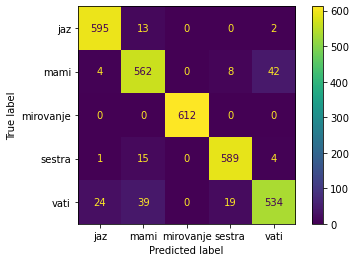

In [31]:

datoteke = ["../../Zajeti_podatki/Hoja_oseb/Rezultati_klasifikacij-X-CUBE-AI/Metoda_podpornih_vektorjev/REZULTATI-Jaz-SVM.csv",
            "../../Zajeti_podatki/Hoja_oseb/Rezultati_klasifikacij-X-CUBE-AI/Metoda_podpornih_vektorjev/REZULTATI-Mami-SVM.csv",
            "../../Zajeti_podatki/Hoja_oseb/Rezultati_klasifikacij-X-CUBE-AI/Metoda_podpornih_vektorjev/REZULTATI-Mirovanje-SVM.csv",
            "../../Zajeti_podatki/Hoja_oseb/Rezultati_klasifikacij-X-CUBE-AI/Metoda_podpornih_vektorjev/REZULTATI-Sestra-SVM.csv",
            "../../Zajeti_podatki/Hoja_oseb/Rezultati_klasifikacij-X-CUBE-AI/Metoda_podpornih_vektorjev/REZULTATI-Vati-SVM.csv"]

imenaRazredov = ["jaz", "mami", "mirovanje", "sestra", "vati"]

CA_F1_Matrix(datoteke, imenaRazredov)

## NanoEdge AI Studio: Izracun klasifikacijske tocnosti in mere F1 ter prikaz tabele napacnih klasifikacij (Rezultati modela metode podpornih vektorjev iz NanoEdge AI Studio)

Klasifikacijska tocnost: 0.5925563173359452
Mera F1: 0.5096355277166625


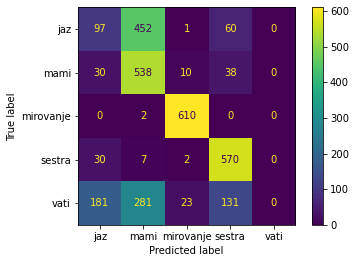

In [3]:
arrayPredicted = [0] * 97 + [1] * 452 + [2] * 1 + [3] * 60 +    [1] * 538 + [0] * 30 + [2] * 10 + [3] * 38 +    [2] * 610 + [1] * 2 +    [3] * 570 + [0] * 30 + [1] * 7 + [2] * 2 +    [4] * 0 + [0] * 181 + [1] * 281 + [2] * 23 + [3] * 131
arrayTrue = [0] * 610 + [1] * 616 + [2] * 612 + [3] * 609 + [4] * 616
imenaRazredov = ["jaz", "mami", "mirovanje", "sestra", "vati"]
NEAIS_CA_F1_Matrix(arrayTrue, arrayPredicted, imenaRazredov)
